In [1]:
import pandas as pd

In [2]:
train = pd.read_csv('AAPL_train.csv')
test = pd.read_csv('AAPL_test.csv')

## ARIMA

In [3]:
#merge = pd.concat([train,test],axis = 0, ignore_index=True)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from utils import *

### Seasonality

In [5]:
train['Date'] = pd.to_datetime(train['Date'])

In [6]:
#merge1 = merge.copy()

In [7]:
train1 = train.set_index('Date')

In [8]:
adj_df = train1['Adj Close']

In [9]:
adj_log = np.log(adj_df)

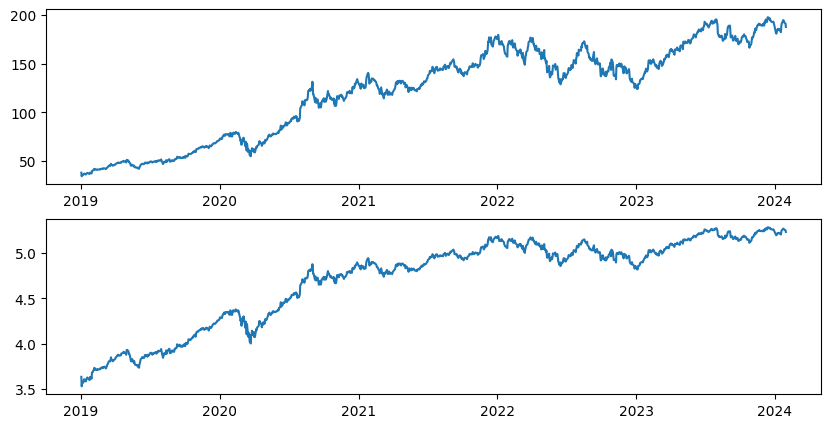

In [10]:
fig,ax = plt.subplots(2,1,figsize=(10,5))
ax[0].plot(adj_df)
ax[1].plot(adj_log)

##### Comment : Difference transform is also volatile --> not likely to have a strong seasonality characteristic

### STATIONARY

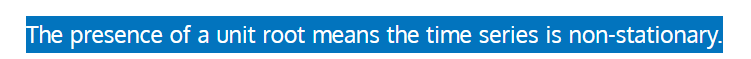
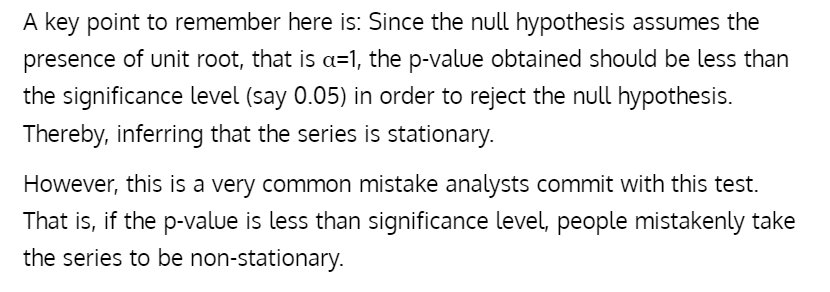

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
# ADF TEST FOR STATIONARY
def stationary_check(df):
    result = adfuller(df)
    print(f'ADF Stats: {result[0]}')
    print(f'p-value : {result[1]}')
    for key, val in result[4].items():
        print(f'Critical values : {key},{val}')
    return

In [13]:
stationary_check(adj_df)

ADF Stats: -1.261018911627535
p-value : 0.646812275201447
Critical values : 1%,-3.4354811617704835
Critical values : 5%,-2.8638059672175684
Critical values : 10%,-2.5679764210546328


In [14]:
stationary_check(adj_log)

ADF Stats: -2.2904942861333994
p-value : 0.17505208394531974
Critical values : 1%,-3.4355176558157616
Critical values : 5%,-2.8638220694163588
Critical values : 10%,-2.5679849962931267


##### comment: p-value larger than 0.05 --> reject H0 --> series is non stationary --> decide the order of differencing

#### DIFFERENCING

In [15]:
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [18]:
# diff1 = adj_df.diff()
def acf_plot(original,order,lag):
    fig,ax = plt.subplots(2,1,figsize=(7,5))
    diff_df = original.diff(periods = order).dropna()
    ax[0].plot(diff_df)
    ax[0].set_title('Difference')

    smt.graphics.plot_acf(diff_df,lags=lag,ax = ax[1])
    plt.tight_layout()


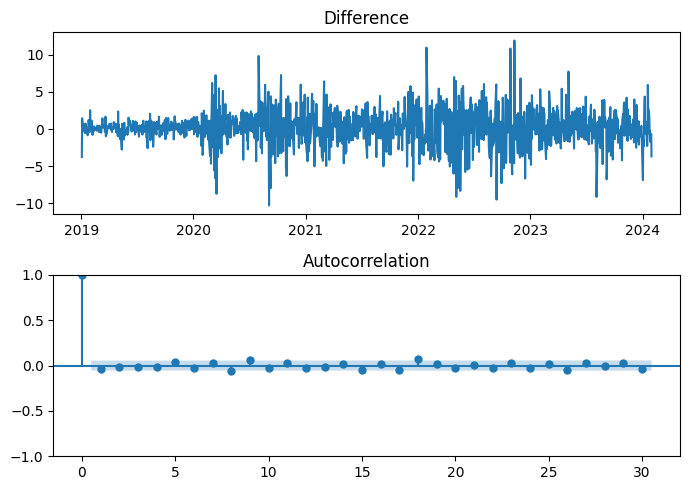

In [19]:
acf_plot(adj_df,1,30)

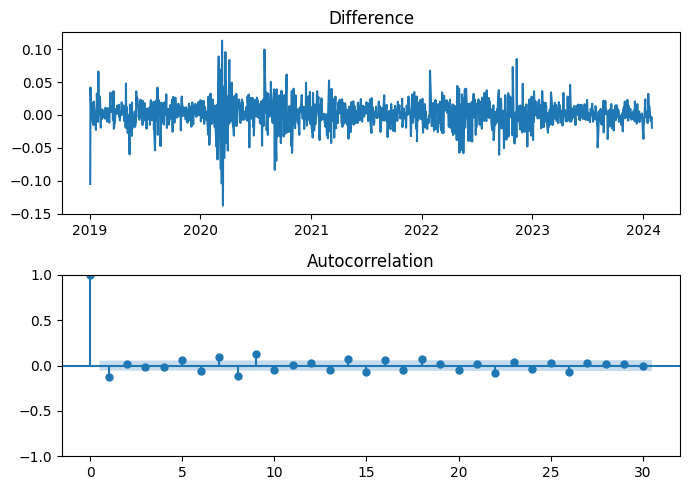

In [20]:
acf_plot(adj_log,1,30)

In [21]:
from pmdarima.arima.utils import ndiffs

In [22]:
ndiffs(adj_df, test="adf",max_d=40)

1

##### Comment: the order of differencing is 1 

### PACF (determining the order of an AR(p) process. Describes the direct relationship between an observation and its lag.)

In [23]:
def pacf_plot(orginal,order,lag):
    fig,ax = plt.subplots(2,1,figsize=(7,5))
    diff_df = orginal.diff(periods = order).dropna()
    ax[0].plot(diff_df)
    ax[0].set_title('Difference')

    smt.graphics.plot_pacf(diff_df,lags=lag,ax=ax[1])
    plt.tight_layout()

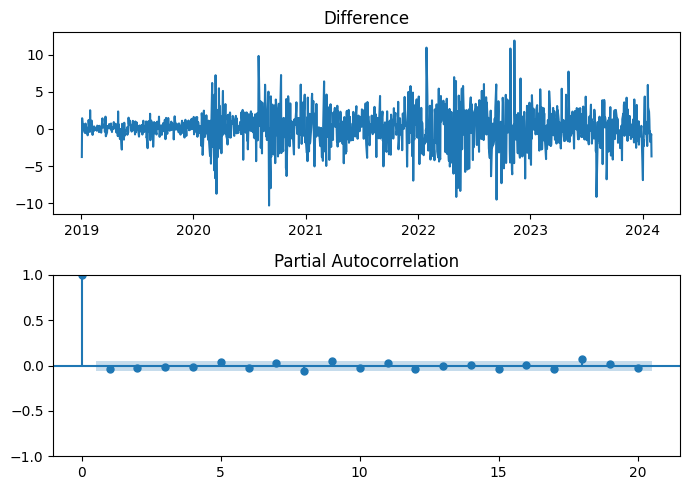

In [24]:
pacf_plot(adj_df,1,20)

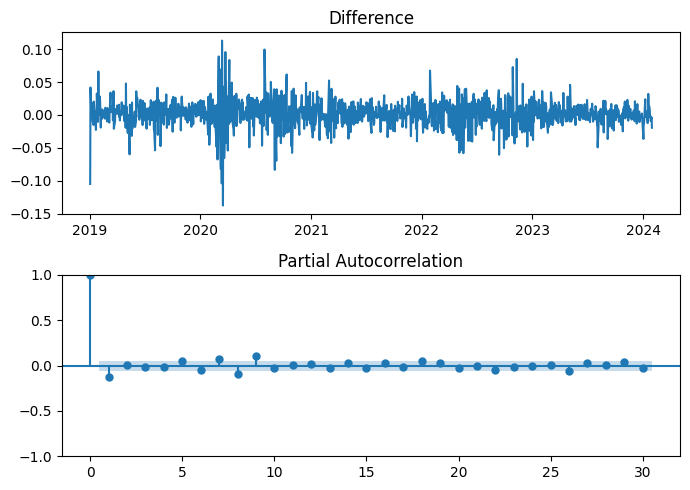

In [25]:
pacf_plot(adj_log,1,30)

#### Comment: The PACF lag of 8 or lag 18 might be outside the significance line  --> AR(8) or AR(18) or AR(0)

### MOVING AVERAGE MA(q)


##### MA(0) - MA(8) hay MA(18) ???

##### Run ADF test on differenced time series

In [26]:
stationary_check(adj_log.diff(periods = 1).dropna())

ADF Stats: -11.199852535842293
p-value : 2.2580709097858342e-20
Critical values : 1%,-3.4355176558157616
Critical values : 5%,-2.8638220694163588
Critical values : 10%,-2.5679849962931267


#### MODELLING

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [28]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(adj_df.values,order = (0,1,0))
re = model.fit()
#print(re.summary())

<Axes: >

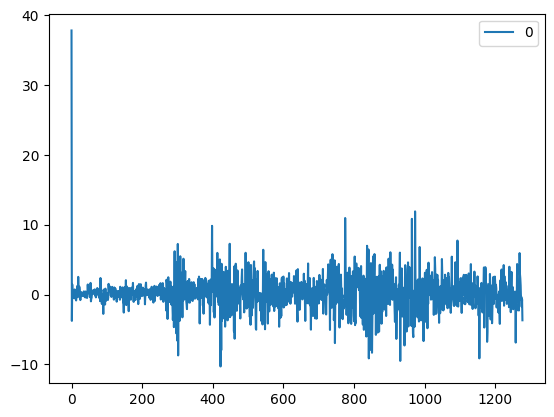

In [29]:
residual = pd.DataFrame(re.resid)
residual.plot()

In [30]:
from pmdarima.arima import auto_arima

In [33]:
auto = auto_arima(adj_df,start_p=1,start_q=1,test='adf',max_p = 5, max_q = 5,d = 1,
                  m=1,seasonal=False,stationary = False,trace = True,error_action='ignore',
                  suppress_warnings=True,stepwise=True)
print(auto.summary())
#auto.plot_diagnostics(figsize=(15,8))
#plt.show()

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5830.836, Time=0.66 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5829.240, Time=0.12 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5829.671, Time=0.38 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5829.599, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5830.378, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 1.449 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1278
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -2912.620
Date:                Tue, 30 Apr 2024   AIC                           5829.240
Time:                        22:21:06   BIC                           5839.545
Sample:                             0   HQIC                          5833.110
                               - 1278                                       

In [34]:
train_size = len(train)
train_size

1278

In [35]:
test['Date'] = pd.to_datetime(test['Date'])
test_val = test.set_index('Date')['Adj Close'].values

In [48]:
from sklearn.metrics import mean_squared_error

train_val = adj_df.values
#train_size = len(train_set)
#train, test = x[0:train_size], x[train_size:]
history = [x for x in train_val]
predictions = []
for t in range(len(test_val)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_val[t]
    history.append(obs)
    #print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test_val, predictions)
print('Test RMSE: %.3f' % np.sqrt(error))

# plt.plot(test_val)
# plt.plot(predictions, color='blue')


Test RMSE: 2.248


In [43]:
len(history)

1328

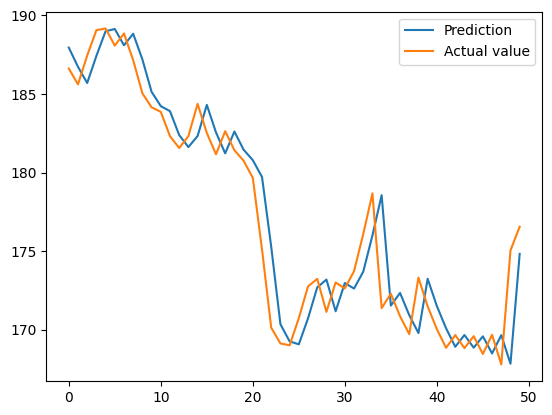

In [37]:
fig,ax = plt.subplots()
ax.plot(predictions, label ='Prediction' )
ax.plot(test_val,label = 'Actual value')
plt.legend()


In [40]:
# from statsmodels.graphics.tsaplots import plot_predict
# fig,ax = plt.subplots(figsize = (15,5))
# #ax = test_adj.plot(ax=ax)
# #adj_df[900:1279].plot(ax=ax)
# #adj_df.plot(ax = ax)
# plot_predict(best_model,start = 1279,end = 1328,ax = ax,dynamic = False)
# plt.show()

In [49]:
#pred = best_model.forecast(50,alpha = 0.05)
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
# report performance
mse = mean_squared_error(test_val, predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_val, predictions)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_val, predictions))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions - test_val)/np.abs(test_val))
print('MAPE: '+str(mape))

MSE: 5.052814588551416
MAE: 1.698024597167971
RMSE: 2.247846655924602
MAPE: 0.009657146383194442


Test RMSE: 2.248


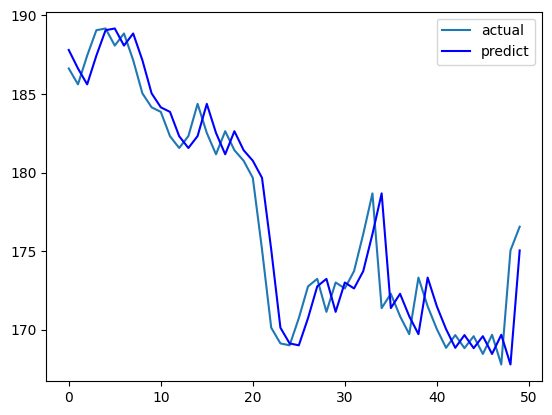

In [44]:
from sklearn.metrics import mean_squared_error

train_val = adj_df.values
#train_size = len(train_set)
#train, test = x[0:train_size], x[train_size:]
history = [x for x in train_val]
predictions1 = []
count = 0
for t in range(len(test_val)):
    model = ARIMA(history, order=(0,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions1.append(yhat)
    obs = test_val[t]
    history.append(obs)
    history = history[1:]
    #print('predicted=%f, actual=%f' % (yhat, obs))
error = mean_squared_error(test_val, predictions1)
print('Test RMSE: %.3f' % np.sqrt(error))

plt.plot(test_val,label = 'actual')
plt.plot(predictions1, color='blue', label = 'predict')
plt.legend()

In [40]:
mse = mean_squared_error(test_val, predictions1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_val, predictions1)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_val, predictions1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions1 - test_val)/np.abs(test_val))
print('MAPE: '+str(mape))

MSE: 5.074834304768673
MAE: 1.7144349690758713
RMSE: 2.25273928912528
MAPE: 0.009748987362569177


In [45]:
mse = mean_squared_error(test_val, predictions1)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_val, predictions1)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_val, predictions1))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(predictions1 - test_val)/np.abs(test_val))
print('MAPE: '+str(mape))

MSE: 5.052814588551416
MAE: 1.698024597167971
RMSE: 2.247846655924602
MAPE: 0.009657146383194442
